# Historical Activation Time for Cyclones 
## Compared to Landfall time

In [1]:
%load_ext jupyter_black
%load_ext autoreload
%autoreload 2

In [2]:
import geopandas as gpd
import pandas as pd
from pathlib import Path
from shapely.geometry import LineString, Point
import os
from datetime import datetime
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from geopy.distance import geodesic

from src import constants
from src.datasources import codab, rsmc

c:\Users\pauni\Desktop\Work\OCHA\GitHub\ds-aa-mdg-storms\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
adm0_path = (
    Path(constants.AA_DATA_DIR)
    / "public"
    / "raw"
    / "mdg"
    / "cod_ab"
    / "mdg_admbnda_adm0_BNGRC_OCHA_20181031.shp"
)
gdf_adm0 = gpd.read_file(adm0_path)
ibtracs_path = adm1_path = (
    Path(constants.AA_DATA_DIR) / "public" / "raw" / "glb" / "ibtracs"
)
points_path = Path(
    ibtracs_path
    / "IBTrACS.SI.list.v04r01.points/IBTrACS.SI.list.v04r01.points.shp"
)

gdf_points = gpd.read_file(points_path)

In [4]:
buffer = True
if buffer:
    # Create buffer around gdf_adm0 with the given distance
    # Reproject to a CRS that uses meters (e.g., EPSG:29702)
    gdf_adm0_buffer = gdf_adm0.to_crs(epsg=constants.mdg_epsg)

    # Apply the buffer of 100 km (100,000 meters)
    gdf_adm0_buffer["geometry"] = gdf_adm0_buffer.geometry.buffer(
        constants.buffer * 1000
    )  # 100 km = 100,000 meters

    # Reproject back to the original CRS
    gdf_adm0_buffer = gdf_adm0_buffer.to_crs(gdf_adm0.crs)
else:
    gdf_adm0_buffer = gdf_adm0.copy()

In [5]:
if gdf_points.crs != gdf_adm0.crs:
    gdf_points = gdf_points.to_crs(gdf_adm0.crs)

In [6]:
def process_ibtracs_activation(gdf_adm):
    # Define the wind speed thresholds
    threshold_speed_64 = 64
    threshold_speed_90 = 90

    # Ensure 'ISO_TIME' is in datetime format
    gdf_points["ISO_TIME"] = pd.to_datetime(gdf_points["ISO_TIME"])

    # Initialize an empty list to store results
    results = []

    # Loop over each storm
    for storm_id, storm_data in gdf_points.groupby("SID"):

        # Sort the storm data by time
        storm_data = storm_data.sort_values("ISO_TIME")

        # Get the storm's name
        storm_name = storm_data.iloc[0]["NAME"]

        # Step 1: Find the first instance of crossing the 64-knot threshold
        crossing_threshold_64 = storm_data[
            storm_data["REU_WIND"] >= threshold_speed_64
        ]
        crossing_time_64 = (
            crossing_threshold_64.iloc[0]["ISO_TIME"]
            if not crossing_threshold_64.empty
            else None
        )
        crossing_location_64 = (
            crossing_threshold_64.iloc[0].geometry
            if not crossing_threshold_64.empty
            else None
        )

        # Step 2: Find the first instance of crossing the 90-knot threshold
        crossing_threshold_90 = storm_data[
            storm_data["REU_WIND"] >= threshold_speed_90
        ]
        crossing_time_90 = (
            crossing_threshold_90.iloc[0]["ISO_TIME"]
            if not crossing_threshold_90.empty
            else None
        )
        crossing_location_90 = (
            crossing_threshold_90.iloc[0].geometry
            if not crossing_threshold_90.empty
            else None
        )

        # Step 3: Find where this storm crosses onto land
        landfall = gpd.sjoin(
            storm_data, gdf_adm, how="inner", predicate="intersects"
        )
        if not landfall.empty:
            # Get the first landfall time and location
            landfall_time = landfall.sort_values("ISO_TIME").iloc[0][
                "ISO_TIME"
            ]
            landfall_location = (
                landfall.sort_values("ISO_TIME").iloc[0].geometry
            )

            # Step 4: Calculate the distance to landfall in kilometers for both thresholds, if locations are available
            distance_to_landfall_64 = None
            distance_to_landfall_90 = None
            if crossing_location_64 is not None:
                crossing_coords_64 = (
                    crossing_location_64.y,
                    crossing_location_64.x,
                )
                landfall_coords = (landfall_location.y, landfall_location.x)
                distance_to_landfall_64 = geodesic(
                    crossing_coords_64, landfall_coords
                ).kilometers
            if crossing_location_90 is not None:
                crossing_coords_90 = (
                    crossing_location_90.y,
                    crossing_location_90.x,
                )
                distance_to_landfall_90 = geodesic(
                    crossing_coords_90, landfall_coords
                ).kilometers

            # Step 5: Calculate the time difference in hours between landfall and crossing times for both thresholds
            time_diff_64 = (
                (landfall_time - crossing_time_64) / pd.Timedelta(hours=1)
                if crossing_time_64
                else None
            )
            time_diff_90 = (
                (landfall_time - crossing_time_90) / pd.Timedelta(hours=1)
                if crossing_time_90
                else None
            )

            # Store the results for each storm
            results.append(
                {
                    "SID": storm_id,
                    "NAME": storm_name,
                    "Landfall_Time": landfall_time,
                    "Crossing_Time_64kt": crossing_time_64,
                    "Crossing_Time_90kt": crossing_time_90,
                    "Distance_to_Landfall_64kt_km": distance_to_landfall_64,
                    "Distance_to_Landfall_90kt_km": distance_to_landfall_90,
                    "Time_Difference_64kt_hrs": time_diff_64,
                    "Time_Difference_90kt_hrs": time_diff_90,
                }
            )

    # Convert results to a DataFrame for easy viewing
    results_df = pd.DataFrame(results)
    return results_df

In [7]:
results_df = process_ibtracs_activation(gdf_adm=gdf_adm0)

In [8]:
results_df[(results_df["NAME"] == "HELLEN")]

,SID,NAME,Landfall_Time,Crossing_Time_64kt,Crossing_Time_90kt,Distance_to_Landfall_64kt_km,Distance_to_Landfall_90kt_km,Time_Difference_64kt_hrs,Time_Difference_90kt_hrs
374,2014086S10041,HELLEN,2014-03-31 18:00:00,2014-03-29 21:00:00,2014-03-30 03:00:00,301.267724,254.436618,45.0,39.0


In [15]:
gdf_points.columns

Index(['SID', 'SEASON', 'NUMBER', 'BASIN', 'SUBBASIN', 'NAME', 'ISO_TIME',
       'NATURE', 'LAT', 'LON',
       ...
       'USA_SEA_SW', 'USA_SEA_NW', 'STORM_SPD', 'STORM_DR', 'year', 'month',
       'day', 'hour', 'min', 'geometry'],
      dtype='object', length=180)

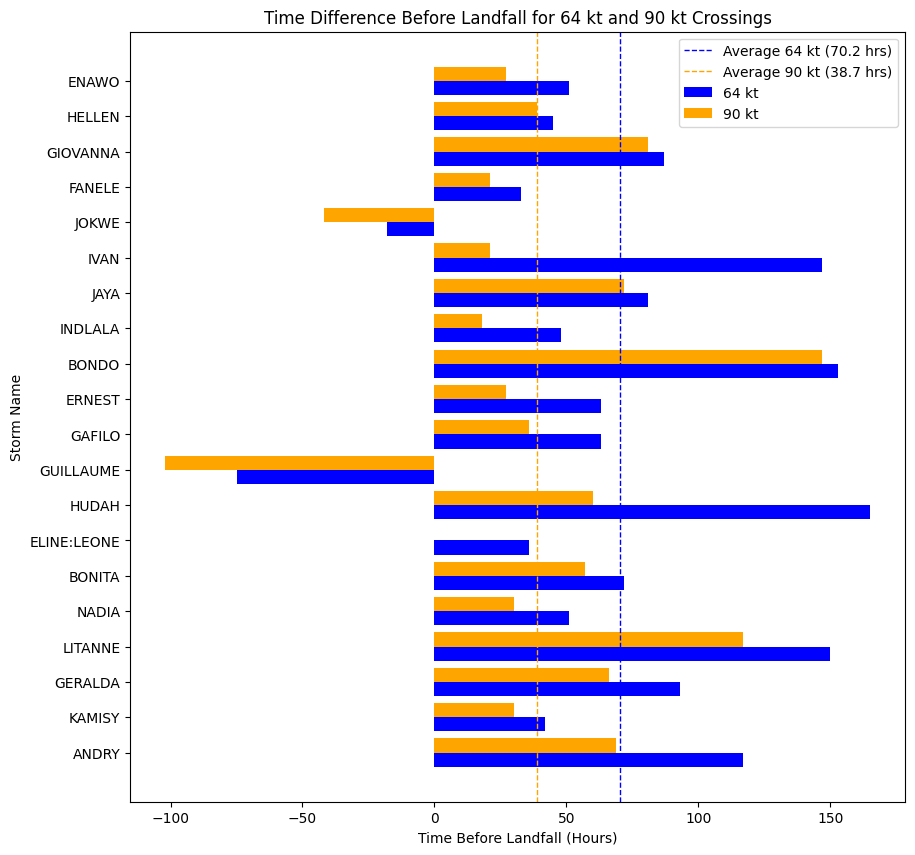

In [9]:
# Filter storms with available time difference data
filtered_df = results_df.dropna(
    subset=["Time_Difference_64kt_hrs", "Time_Difference_90kt_hrs"]
)

# Calculate the average time difference for 64-knot and 90-knot crossings
avg_time_diff_64 = filtered_df["Time_Difference_64kt_hrs"].mean()
avg_time_diff_90 = filtered_df["Time_Difference_90kt_hrs"].mean()

# Set up positions for grouped bars
ind = np.arange(len(filtered_df))  # Position for each storm
bar_width = 0.4  # Width for each bar

# Plot the grouped bars for time differences
plt.figure(
    figsize=(10, len(filtered_df) * 0.5)
)  # Adjust height based on the number of storms
plt.barh(
    ind - bar_width / 2,
    filtered_df["Time_Difference_64kt_hrs"],
    height=bar_width,
    color="blue",
    label="64 kt",
)
plt.barh(
    ind + bar_width / 2,
    filtered_df["Time_Difference_90kt_hrs"],
    height=bar_width,
    color="orange",
    label="90 kt",
)

# Add average time difference lines for both thresholds
plt.axvline(
    avg_time_diff_64,
    color="blue",
    linestyle="--",
    linewidth=1,
    label=f"Average 64 kt ({avg_time_diff_64:.1f} hrs)",
)
plt.axvline(
    avg_time_diff_90,
    color="orange",
    linestyle="--",
    linewidth=1,
    label=f"Average 90 kt ({avg_time_diff_90:.1f} hrs)",
)

# Adding labels and title
plt.yticks(ind, filtered_df["NAME"])
plt.xlabel("Time Before Landfall (Hours)")
plt.ylabel("Storm Name")
plt.title("Time Difference Before Landfall for 64 kt and 90 kt Crossings")
plt.legend()
plt.show()

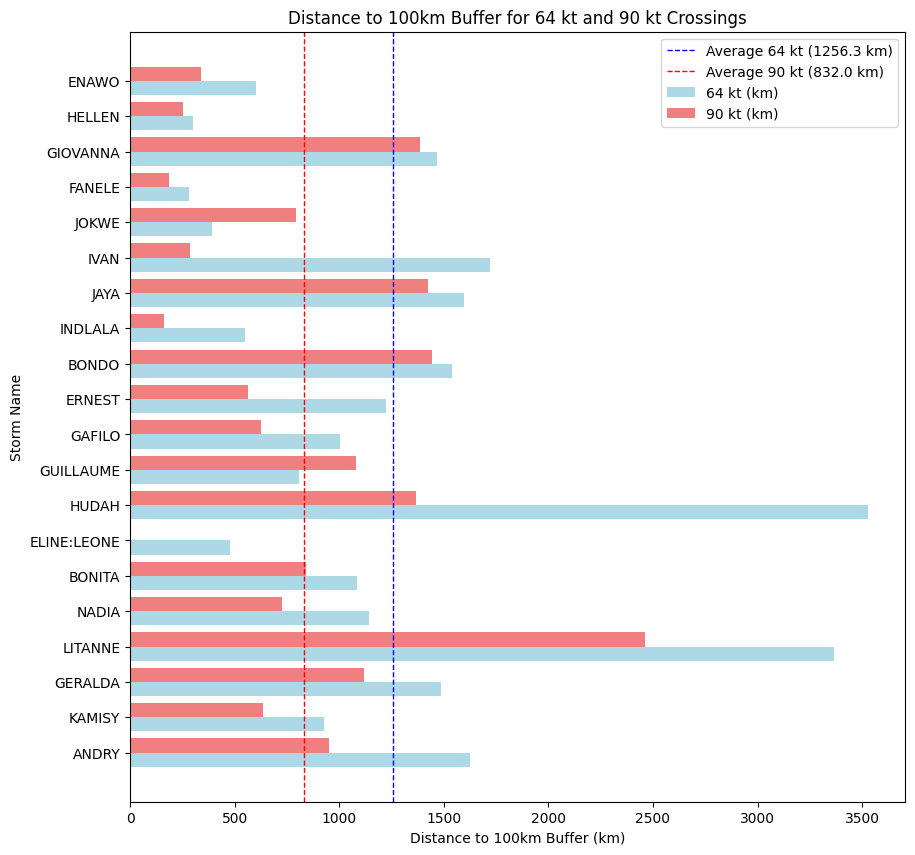

In [10]:
# Filter storms with available distance data
filtered_df = results_df.dropna(
    subset=["Distance_to_Landfall_64kt_km", "Distance_to_Landfall_90kt_km"]
)

# Set positions for each storm
ind = np.arange(len(filtered_df))  # Position for each storm
bar_width = 0.4  # Width for each bar in the group

# Calculate the average distances for 64 kt and 90 kt thresholds
avg_distance_64 = filtered_df["Distance_to_Landfall_64kt_km"].mean()
avg_distance_90 = filtered_df["Distance_to_Landfall_90kt_km"].mean()

# Plot the grouped bars
plt.figure(
    figsize=(10, len(filtered_df) * 0.5)
)  # Adjust height based on number of storms
plt.barh(
    ind - bar_width / 2,
    filtered_df["Distance_to_Landfall_64kt_km"],
    height=bar_width,
    color="lightblue",
    label="64 kt (km)",
)
plt.barh(
    ind + bar_width / 2,
    filtered_df["Distance_to_Landfall_90kt_km"],
    height=bar_width,
    color="lightcoral",
    label="90 kt (km)",
)

# Add average lines for both thresholds
plt.axvline(
    avg_distance_64,
    color="blue",
    linestyle="--",
    linewidth=1,
    label=f"Average 64 kt ({avg_distance_64:.1f} km)",
)
plt.axvline(
    avg_distance_90,
    color="red",
    linestyle="--",
    linewidth=1,
    label=f"Average 90 kt ({avg_distance_90:.1f} km)",
)

# Adding labels and title
plt.xlabel("Distance to 100km Buffer (km)")
plt.yticks(ind, filtered_df["NAME"])
plt.ylabel("Storm Name")
plt.title("Distance to 100km Buffer for 64 kt and 90 kt Crossings")
plt.legend()
plt.show()

In [11]:
results_df = process_ibtracs_activation(gdf_adm=gdf_adm0_buffer)

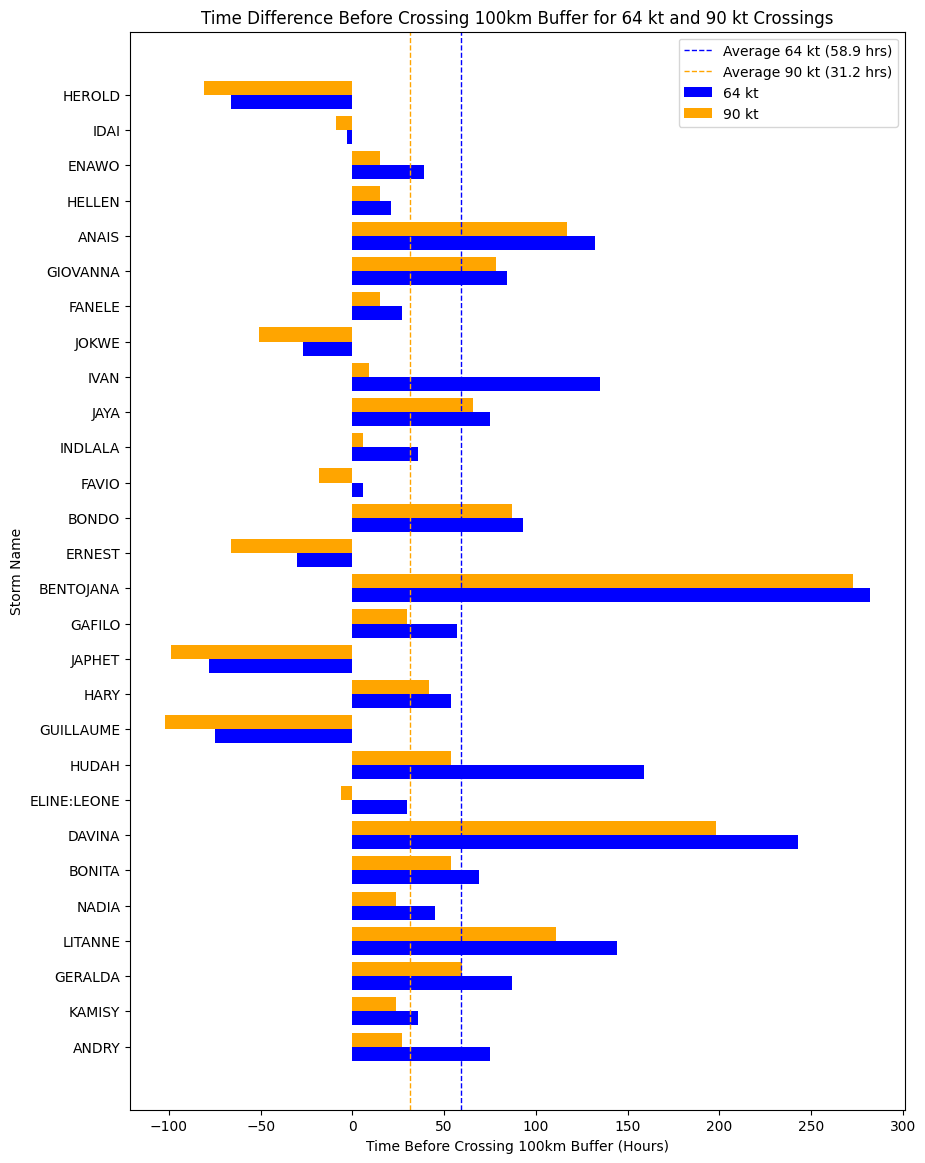

In [12]:
# Filter storms with available time difference data
filtered_df = results_df.dropna(
    subset=["Time_Difference_64kt_hrs", "Time_Difference_90kt_hrs"]
)

# Calculate the average time difference for 64-knot and 90-knot crossings
avg_time_diff_64 = filtered_df["Time_Difference_64kt_hrs"].mean()
avg_time_diff_90 = filtered_df["Time_Difference_90kt_hrs"].mean()

# Set up positions for grouped bars
ind = np.arange(len(filtered_df))  # Position for each storm
bar_width = 0.4  # Width for each bar

# Plot the grouped bars for time differences
plt.figure(
    figsize=(10, len(filtered_df) * 0.5)
)  # Adjust height based on the number of storms
plt.barh(
    ind - bar_width / 2,
    filtered_df["Time_Difference_64kt_hrs"],
    height=bar_width,
    color="blue",
    label="64 kt",
)
plt.barh(
    ind + bar_width / 2,
    filtered_df["Time_Difference_90kt_hrs"],
    height=bar_width,
    color="orange",
    label="90 kt",
)

# Add average time difference lines for both thresholds
plt.axvline(
    avg_time_diff_64,
    color="blue",
    linestyle="--",
    linewidth=1,
    label=f"Average 64 kt ({avg_time_diff_64:.1f} hrs)",
)
plt.axvline(
    avg_time_diff_90,
    color="orange",
    linestyle="--",
    linewidth=1,
    label=f"Average 90 kt ({avg_time_diff_90:.1f} hrs)",
)

# Adding labels and title
plt.yticks(ind, filtered_df["NAME"])
plt.xlabel("Time Before Crossing 100km Buffer (Hours)")
plt.ylabel("Storm Name")
plt.title(
    "Time Difference Before Crossing 100km Buffer for 64 kt and 90 kt Crossings"
)
plt.legend()
plt.show()

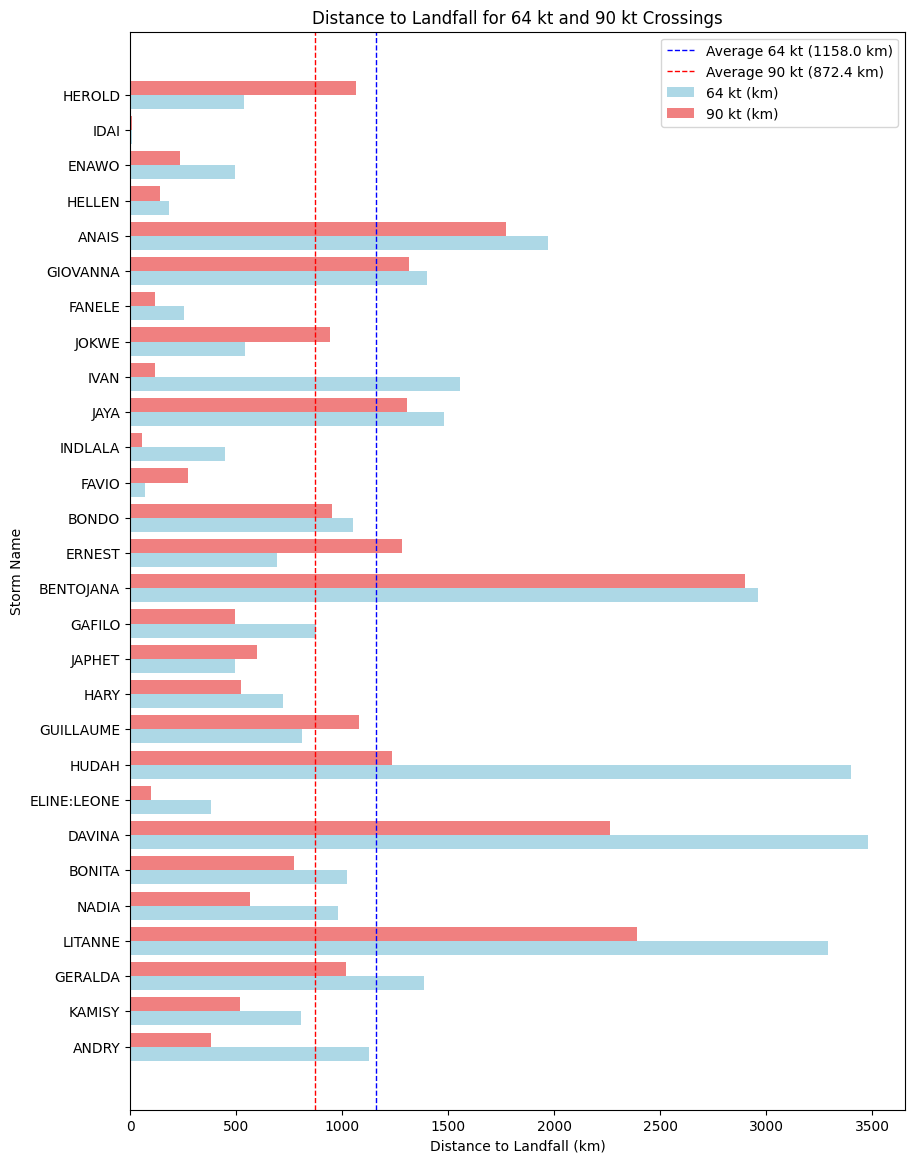

In [13]:
# Filter storms with available distance data
filtered_df = results_df.dropna(
    subset=["Distance_to_Landfall_64kt_km", "Distance_to_Landfall_90kt_km"]
)

# Set positions for each storm
ind = np.arange(len(filtered_df))  # Position for each storm
bar_width = 0.4  # Width for each bar in the group

# Calculate the average distances for 64 kt and 90 kt thresholds
avg_distance_64 = filtered_df["Distance_to_Landfall_64kt_km"].mean()
avg_distance_90 = filtered_df["Distance_to_Landfall_90kt_km"].mean()

# Plot the grouped bars
plt.figure(
    figsize=(10, len(filtered_df) * 0.5)
)  # Adjust height based on number of storms
plt.barh(
    ind - bar_width / 2,
    filtered_df["Distance_to_Landfall_64kt_km"],
    height=bar_width,
    color="lightblue",
    label="64 kt (km)",
)
plt.barh(
    ind + bar_width / 2,
    filtered_df["Distance_to_Landfall_90kt_km"],
    height=bar_width,
    color="lightcoral",
    label="90 kt (km)",
)

# Add average lines for both thresholds
plt.axvline(
    avg_distance_64,
    color="blue",
    linestyle="--",
    linewidth=1,
    label=f"Average 64 kt ({avg_distance_64:.1f} km)",
)
plt.axvline(
    avg_distance_90,
    color="red",
    linestyle="--",
    linewidth=1,
    label=f"Average 90 kt ({avg_distance_90:.1f} km)",
)

# Adding labels and title
plt.xlabel("Distance to Landfall (km)")
plt.yticks(ind, filtered_df["NAME"])
plt.ylabel("Storm Name")
plt.title("Distance to Landfall for 64 kt and 90 kt Crossings")
plt.legend()
plt.show()